In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
blastchar_telco_customer_churn_path = kagglehub.dataset_download('blastchar/telco-customer-churn')

print('Data source import complete.')


Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


**Telco Customer Churn Analysis**
This notebook explores the Telco Customer Churn dataset to understand customer behavior patterns and identify factors that contribute to customer churn.
We'll perform exploratory data analysis (EDA) with various visualizations to uncover insights about customer retention and attrition.We'll also build supervised learning models to predict whether a customer will churn or not.Logistic Regression and K-Nearest Neighbors (KNN) models are evaluated using metrics aligned with business objectives, with a main focus on recall and AUC.

**1. Import Libraries and Setup**
First, we import all necessary libraries for data manipulation, visualization, and analysis:

1. **pandas** and **numpy** for data processing
2. **matplotlib** and **seaborn** for static visualizations
3. **plotly** for interactive charts
We also configure visualization settings and suppress warnings for cleaner output.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report , confusion_matrix , roc_curve , roc_auc_score
# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

print("Libraries Imported Successfully")

Libraries Imported Successfully


**2. Load Dataset**
We load the **Telco Customer Churn** dataset from the Kaggle input directory. This dataset contains information about telecom customers, their services, account details, and whether they churned (left the company) or not.

The dataset path is configured for the standard Kaggle environment.

In [4]:
try:
    df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Dataset Loaded Successfully")
except FileNotFoundError:
    print("File not found. Please add the 'Telco Customer Churn' dataset to your notebook.")

Dataset Loaded Successfully


**3. Initial Data Exploration and Cleaning**
In this section, we perform initial data exploration to understand the structure and quality of our dataset:

**1. Display dataset information -** Check data types and non-null counts
**2. Preview the data -** View the first few rows
**3. Data type conversion -** Convert TotalCharges to numeric (it contains spaces instead of NaN values)
**4. Handle missing values -** Fill missing values in TotalCharges (these are new customers with tenure=0)
**5. Check for duplicates -** Ensure data integrity
**6. Generate descriptive statistics -** Understand numerical feature distributions
**7. Create binary target variable -** Convert 'Yes'/'No' to 1/0 for correlation analysis

In [5]:
print("\n--- Dataset Information ---")
df.info()

print("\n--- First 5 Rows ---")
display(df.head())

# Convert TotalCharges to numeric type (contains spaces instead of NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values
missing_values = df.isnull().sum()
print("\n--- Missing Values ---")
print(missing_values[missing_values > 0])

# Fill missing values (only 11 missing values - new customers with tenure=0)
df['TotalCharges'].fillna(0, inplace=True)

# Check for duplicates
print(f"\nDuplicates found: {df.duplicated().sum()}")

# Descriptive statistics for numerical features
print("\n--- Descriptive Statistics (Numerical Features) ---")
display(df.describe())

# Create binary target variable for correlation analysis
df['Churn_Binary'] = df['Churn'].map({'Yes': 1, 'No': 0})


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBill

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



--- Missing Values ---
TotalCharges    11
dtype: int64

Duplicates found: 0

--- Descriptive Statistics (Numerical Features) ---


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


**4. Visualization 1: Target Variable Distribution¶**
We visualize the distribution of our target variable (Churn) using a pie chart. This helps us understand:

The proportion of customers who churned vs. those who stayed
Whether we have a balanced or imbalanced dataset
This is crucial for understanding the baseline and potential class imbalance issues in predictive modeling.

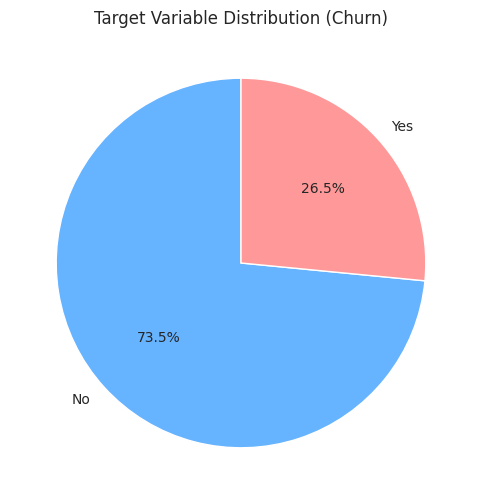

In [6]:
plt.figure(figsize=(6, 6))
churn_counts = df['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%',
        colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Target Variable Distribution (Churn)')
plt.show()

**5. Visualization 2:** Numerical Feature Distributions
We create histograms with kernel density estimation (KDE) for three key numerical features:
* **Tenure -** Number of months the customer has been with the company
* **Monthly Charges -** The amount charged to the customer monthly
* **Total Charges -** Total amount charged to the customer

These distributions help us understand:
* Customer loyalty patterns (tenure)
* Pricing structure and customer segments (charges)
* Potential outliers or unusual patterns

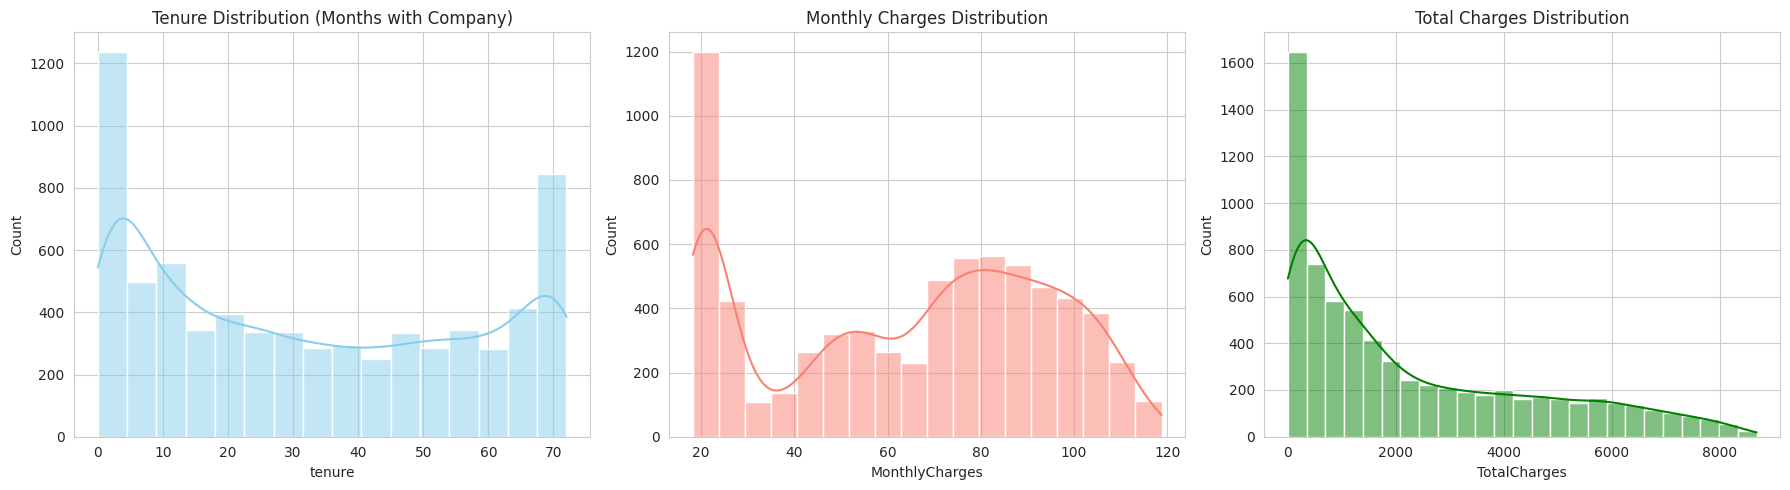

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['tenure'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Tenure Distribution (Months with Company)')

sns.histplot(df['MonthlyCharges'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Monthly Charges Distribution')

sns.histplot(df['TotalCharges'], kde=True, ax=axes[2], color='green')
axes[2].set_title('Total Charges Distribution')

plt.tight_layout()
plt.show()

**6. Visualization 3: Churn by Contract Type**
This count plot shows the relationship between contract type and customer churn. We examine three contract types:
* **Month-to-month**
* **One year**
* **Two year**


This visualization helps identify:

* Which contract types have higher churn rates
* The effectiveness of long-term contracts in retaining customers
* Potential areas for business strategy improvement

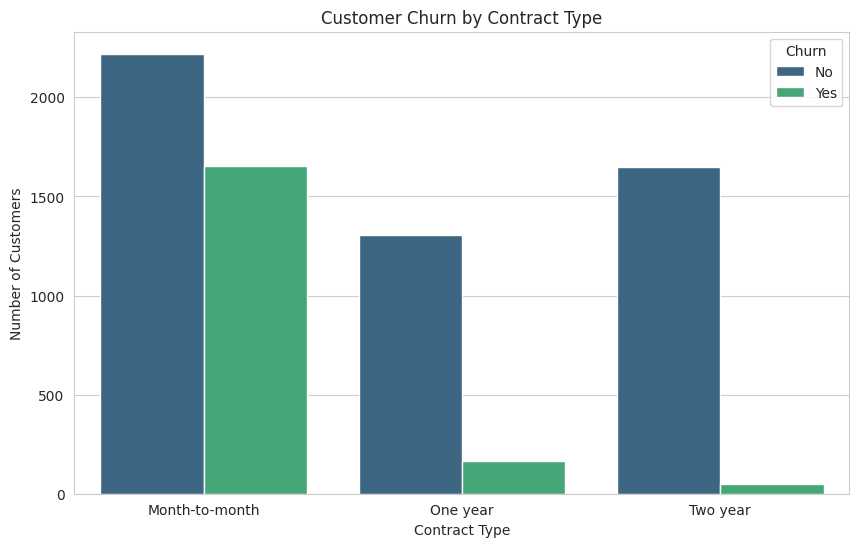

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Contract', hue='Churn', palette='viridis')
plt.title('Customer Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()

**7. Visualization 4: Numerical Features vs Churn (Box Plots)**¶
Box plots help us compare the distribution of numerical features between churned and retained customers:
* **Tenure vs Churn -** Do customers who stay longer churn less?
* **Monthly Charges vs Churn -** Does pricing affect churn rates?


These plots reveal:
* Median values and quartiles for each group
* Outliers in the data
* Clear differences between churned and retained customer segments

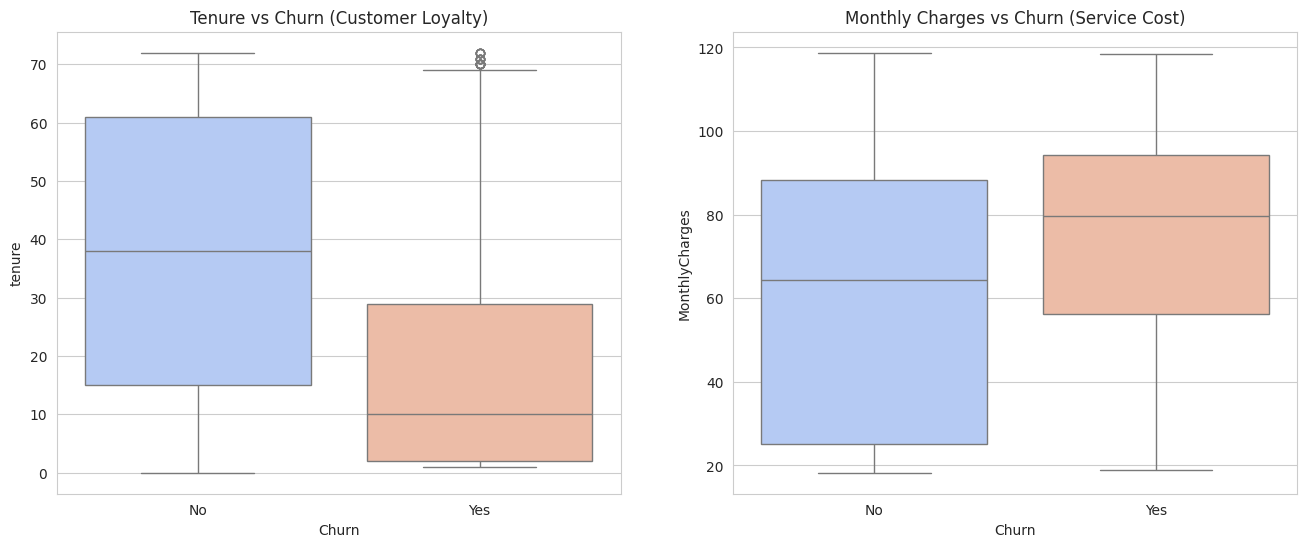

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='Churn', y='tenure', data=df, ax=axes[0], palette='coolwarm')
axes[0].set_title('Tenure vs Churn (Customer Loyalty)')

sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1], palette='coolwarm')
axes[1].set_title('Monthly Charges vs Churn (Service Cost)')

plt.show()

**8. Visualization 5: Correlation Heatmap**
Finally, we create a correlation heatmap to understand the relationships between numerical features and the target variable (Churn).

The heatmap shows:

* **Positive correlations -** Features that increase together
* **Negative correlations -** Features that move in opposite directions
* **Strength of relationships -** Values closer to 1 or -1 indicate stronger correlations


This helps identify:

* Which features are most predictive of churn
* Multicollinearity between features
* Key drivers of customer behavior

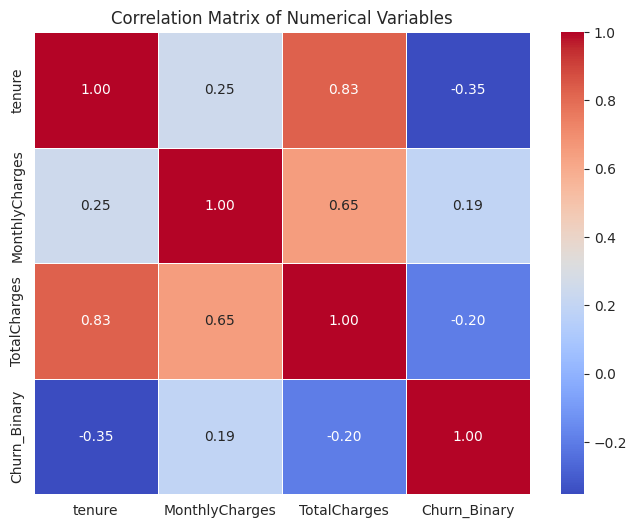

In [10]:
numeric_df = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Binary']]
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

**9. Visualization 6 Violin Plot**
Monthly Charges Distribution by Contract Type This violin plot visualizes the relationship between Monthly Charges, Contract Type, and Churn.

**Key Insight:** The plot reveals that customers with Month-to-month contracts who pay higher monthly amounts (wider top section of the orange violin) are significantly more likely to churn compared to those with long-term contracts.

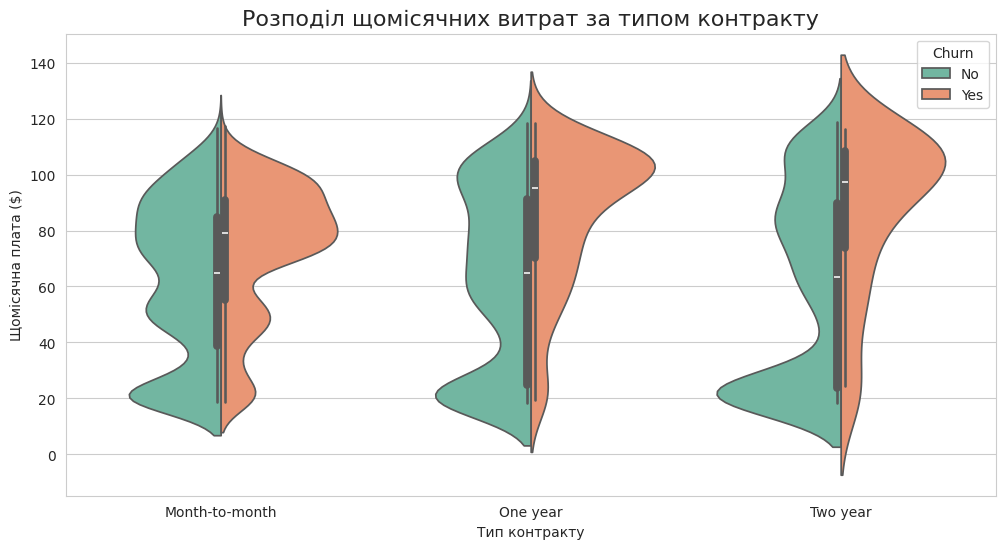

In [11]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Contract', y='MonthlyCharges', hue='Churn', data=df, split=True, palette='Set2')

plt.title('Розподіл щомісячних витрат за типом контракту', fontsize=16)
plt.xlabel('Тип контракту')
plt.ylabel('Щомісячна плата ($)')
plt.show()

**10. Visualization 7 Correlation Bar Chart**



Data preparation


In [12]:
df_clean = df.copy()

if 'customerID' in df_clean.columns:
    df_clean = df_clean.drop('customerID', axis=1)

df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce').fillna(0)

df_dummy = pd.get_dummies(df_clean, drop_first=True)

**We calculate the correlation**

In [13]:
target_col = 'Churn_Yes' if 'Churn_Yes' in df_dummy.columns else 'Churn_1'
if target_col not in df_dummy.columns:
    df_dummy['Churn_Target'] = df_clean['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
    target_col = 'Churn_Target'
    if 'Churn_Yes' in df_dummy.columns: df_dummy = df_dummy.drop('Churn_Yes', axis=1) # чистимо дублі

corr_values = df_dummy.corr()[target_col].sort_values(ascending=False)

corr_values = corr_values.drop(target_col)

**We choose the TOP-10 factors that contribute to outflow and the TOP-10 that retain**

In [14]:
top_positive = corr_values.head(10)
top_negative = corr_values.tail(10)
plot_data = pd.concat([top_positive, top_negative])

**We draw a beautiful graph**

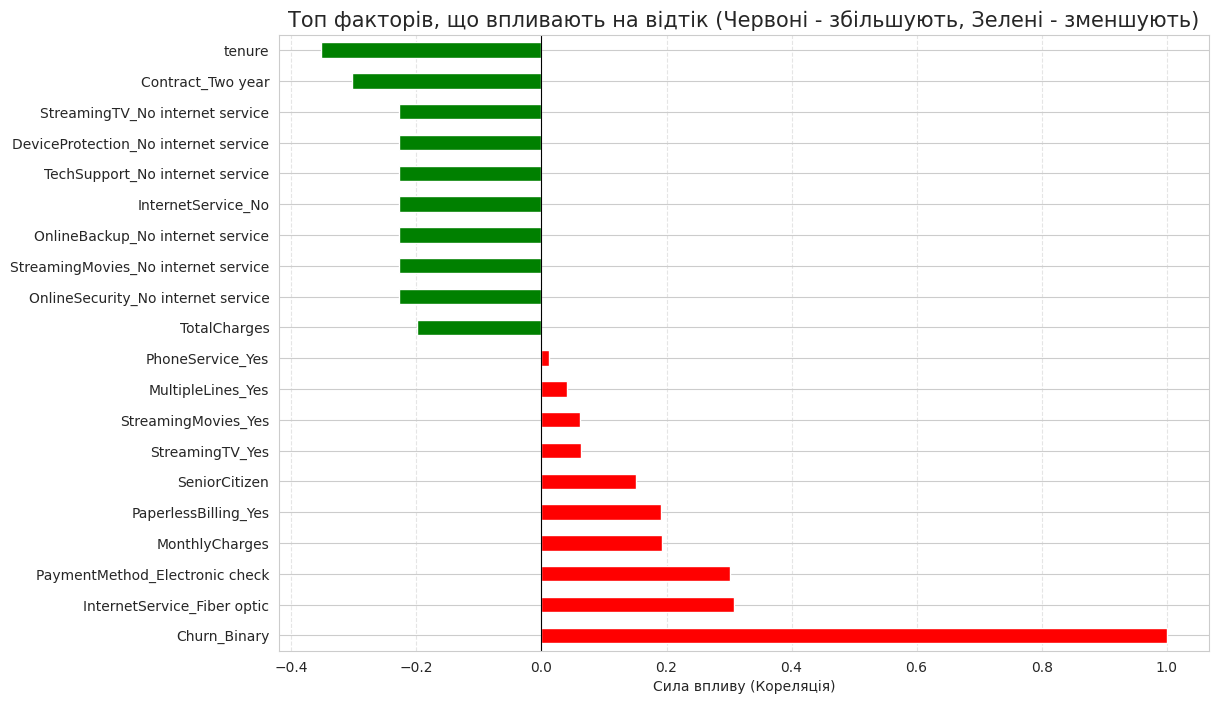

In [15]:
plt.figure(figsize=(12, 8))
colors = ['red' if x > 0 else 'green' for x in plot_data.values]
plot_data.plot(kind='barh', color=colors)

plt.title('Топ факторів, що впливають на відтік (Червоні - збільшують, Зелені - зменшують)', fontsize=15)
plt.xlabel('Сила впливу (Кореляція)')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

**11.Exploratory Data Analysis (EDA)**


Target Variable Distribution


Understanding the distribution of the target variable is crucial.

In [16]:
df["Churn"].value_counts()

,count
Churn,
No,5174
Yes,1869


In [17]:
df["Churn"].value_counts(normalize = True) * 100

,proportion
Churn,
No,73.463013
Yes,26.536987


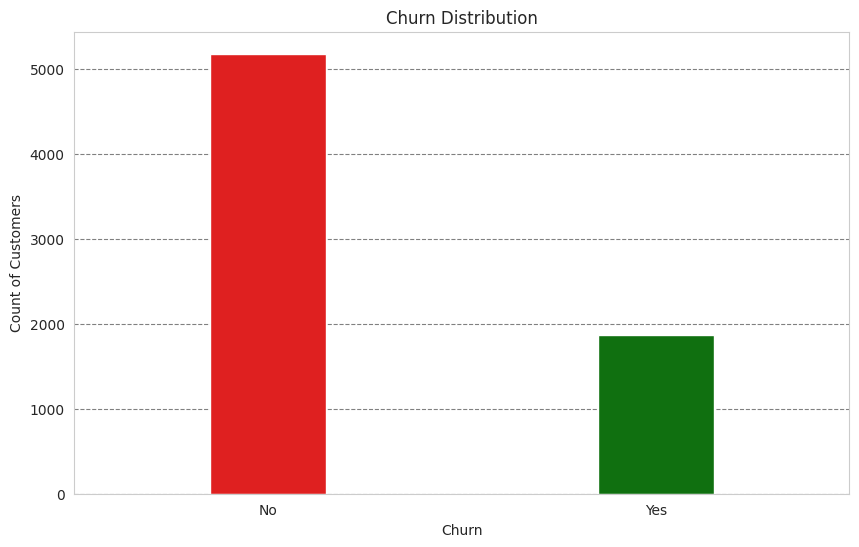

In [18]:
sns.countplot(data = df , x = "Churn" , palette =["Red","Green"] , width = 0.3)
plt.title("Churn Distribution")
plt.ylabel("Count of Customers")
plt.grid(True , axis = "y", color = "gray" , linestyle = "--")
plt.show()

From the distribution plot , we can see that the dataset is imbalanced , with significantly more non-churn customers than churn customers.

EDA - Numerical Features Overview

In [19]:
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [20]:
df.duplicated().sum()

np.int64(0)

In [21]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn_Binary
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.265370
std,0.368612,24.559481,30.090047,2266.794470,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,398.550000,0.000000
50%,0.000000,29.000000,70.350000,1394.550000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


**Data Preprocessing**


In this section, data quality issues identified during EDA will be handled, and the dataset will be prepared for modeling.

Missing Value Operations

In [22]:
df = df.dropna(subset = ["TotalCharges"])
display(df.isna().sum())
display(df.shape)

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


(7043, 22)

Since the proportion of missing values is very small (less than 5%), the corresponding rows were removed.

**Categorical Encoding**


Categorical variables will be converted into numerical format using one-hot encoding to make them suitable for machine learning models.

Target variable column will be seperated before encoding.

In [23]:
y = df["Churn"]
X = df.drop(["Churn","customerID"] , axis = 1)

Let's also convert the target variable to binary values.

In [24]:
y = y.map({"Yes" : 1 , "No" : 0})
print(y.head(3))

0    0
1    0
2    1
Name: Churn, dtype: int64


In [25]:
X_encoded = pd.get_dummies(X, drop_first=True)

When applying one-hot encoding, one category from each categorical feature is intentionally dropped (drop_first = True) to avoid the **dummy variable trap**. Since the dropped category can be inferred from the remaining dummy variables,no information is lost.

In [26]:
display(X_encoded.shape)
display(X_encoded.columns)

(7043, 31)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'Churn_Binary', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [27]:
for col in X.columns:
    print(col , X[col].nunique())

gender 2
SeniorCitizen 2
Partner 2
Dependents 2
tenure 73
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1585
TotalCharges 6531
Churn_Binary 2


We can see that dummy operations are correctly done.



Model Preparation



In this section, the dataset is prepared for machine learning models. This includes splitting the data into training and test sets and applying feature scaling to ensure optimal model performance.

Train-Test Split

In [28]:
X_train , X_test , y_train , y_test = train_test_split(X_encoded,
                                                       y,
                                                       test_size = 0.2,
                                                       random_state = 12,
                                                       stratify = y)

**Feature Scaling**


Feature scaling was applied to ensure that all features contribute equally to the model, which is particularly important for distance-based algorithms such as k-Nearest Neighbors.

In [29]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Logistic Regression Model**


Logistic Regression will be used as the main model due to its simplicity and interpretability for binary classification problems.

In [30]:
log_reg = LogisticRegression()

log_reg.fit(X_train_scaled , y_train)

y_pred_log_reg = log_reg.predict(X_test_scaled)

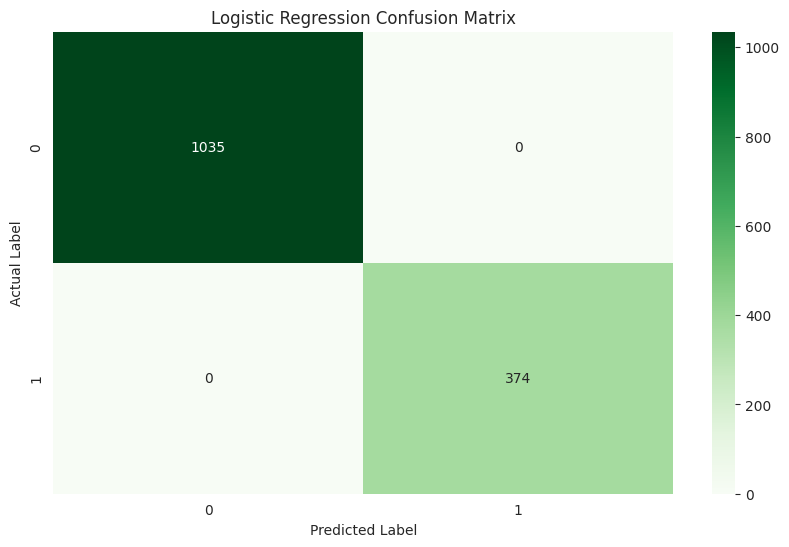

In [31]:
conf_matrix_log_reg = confusion_matrix(y_test , y_pred_log_reg)

sns.heatmap(conf_matrix_log_reg , annot=True , fmt = "d" , cmap = "Greens")

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [32]:
y_prob_log_reg = log_reg.predict_proba(X_test_scaled)[: ,1]

fpr , tpr ,threshold = roc_curve(y_test , y_prob_log_reg)

roc_auc_log_reg = roc_auc_score(y_test , y_prob_log_reg)

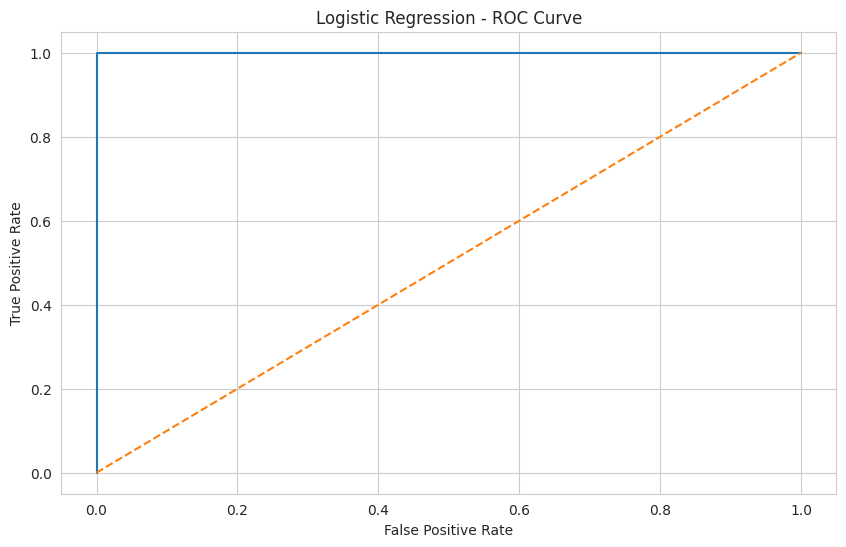

'Area under the ROC Curve : 1.0'

In [33]:
plt.plot(fpr , tpr)
plt.plot([0,1] , [0,1] , linestyle ="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression - ROC Curve")
plt.show()

display(f"Area under the ROC Curve : {roc_auc_log_reg}")

In [34]:
log_reg_report = pd.DataFrame(classification_report(y_test , y_pred_log_reg , output_dict = True))
display(log_reg_report)

,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,1035.0,374.0,1.0,1409.0,1409.0


In [35]:
k_values = range(1,41)
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled , y_train)

    y_prob = knn.predict_proba(X_test_scaled)[:,1]
    auc_score = roc_auc_score(y_test , y_prob)
    results.append(auc_score)

display(results)

[np.float64(0.9645327959905966),
 np.float64(0.9889986824769434),
 np.float64(0.9930687953705857),
 np.float64(0.9944250691053761),
 np.float64(0.9942661913250147),
 np.float64(0.9967449430365032),
 np.float64(0.996778526957555),
 np.float64(0.9968805704099822),
 np.float64(0.9969490299413573),
 np.float64(0.9968301945284043),
 np.float64(0.9971569919140252),
 np.float64(0.9969438631842724),
 np.float64(0.9971621586711101),
 np.float64(0.9973752874008629),
 np.float64(0.9972861608411479),
 np.float64(0.9972370766488414),
 np.float64(0.9982639696194684),
 np.float64(0.998138675760159),
 np.float64(0.998046965821902),
 np.float64(0.9980973417034797),
 np.float64(0.9986140174119714),
 np.float64(0.9985739750445632),
 np.float64(0.9984913069312047),
 np.float64(0.9983053036761477),
 np.float64(0.9985468495698673),
 np.float64(0.9984409310496267),
 np.float64(0.9985068072024594),
 np.float64(0.9983931385465912),
 np.float64(0.9982433025911287),
 np.float64(0.9982471776589423),
 np.float64(0

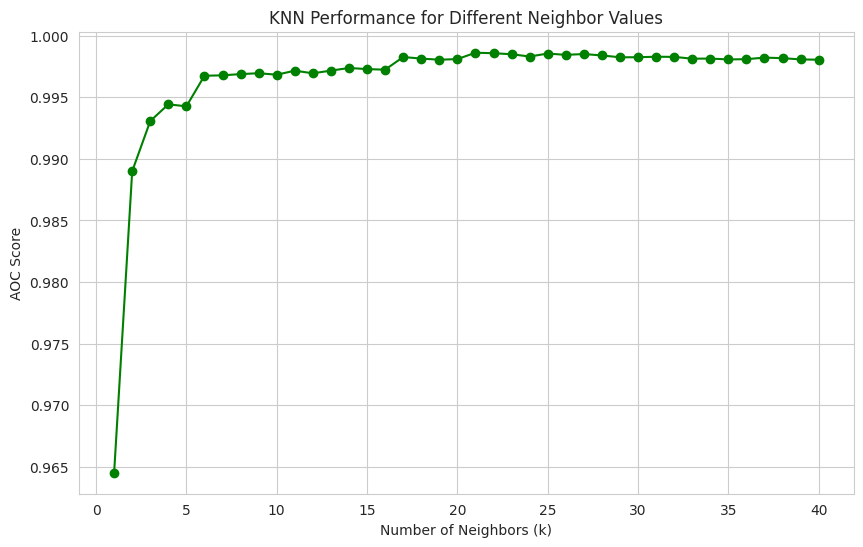

In [36]:
plt.plot(k_values , results , marker = "o" , color = "green")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("AOC Score")
plt.title("KNN Performance for Different Neighbor Values")

plt.show()


In [37]:
knn = KNeighborsClassifier(n_neighbors = 31)

knn.fit(X_train_scaled , y_train)

KNeighborsClassifier(n_neighbors=31)

In [38]:
y_pred_knn = knn.predict(X_test_scaled)

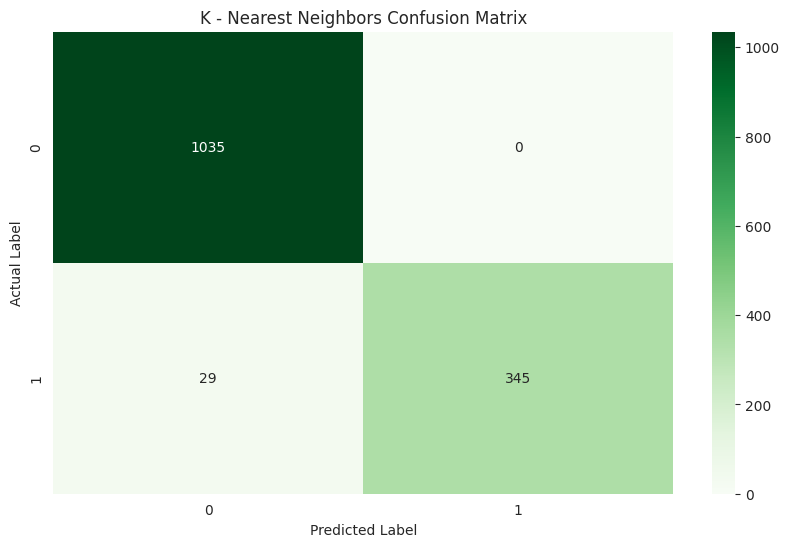

In [39]:
conf_matrix_knn = confusion_matrix(y_test , y_pred_knn)

sns.heatmap(conf_matrix_knn , annot = True , fmt ="d" , cmap = "Greens")

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("K - Nearest Neighbors Confusion Matrix")
plt.show()

In [40]:
y_prob_knn = knn.predict_proba(X_test_scaled)[: , 1]

fpr_knn , tpr_knn , threshold_knn = roc_curve(y_test , y_prob_knn)

roc_auc_knn = roc_auc_score(y_test , y_prob_knn)

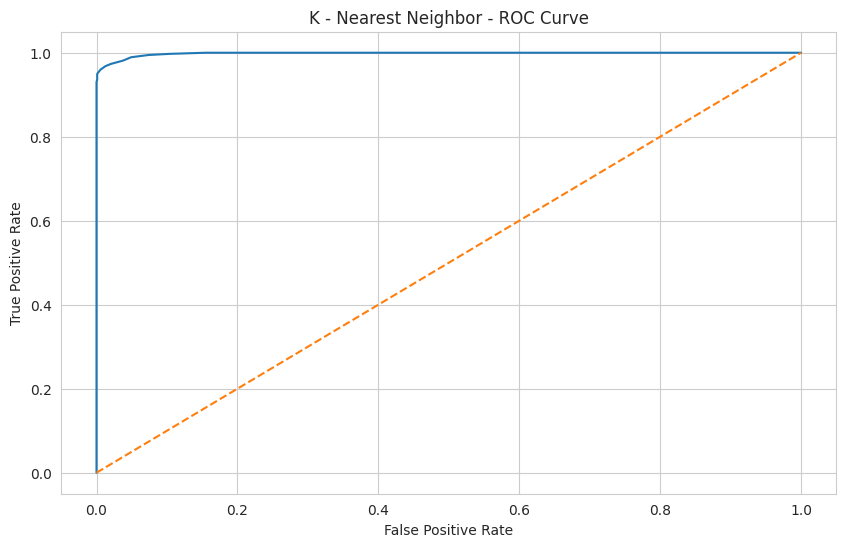

'Area under the ROC Curve : 0.998289803404893'

In [41]:
plt.plot(fpr_knn , tpr_knn)
plt.plot([0,1] , [0,1] , linestyle = "--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("K - Nearest Neighbor - ROC Curve")
plt.show()

display (f"Area under the ROC Curve : {roc_auc_knn}")

In [42]:
knn_report = pd.DataFrame(classification_report(y_test , y_pred_knn , output_dict = True))
display(knn_report)

,0,1,accuracy,macro avg,weighted avg
precision,0.972744,1.000000,0.979418,0.986372,0.979979
recall,1.000000,0.922460,0.979418,0.961230,0.979418
f1-score,0.986184,0.959666,0.979418,0.972925,0.979145
support,1035.000000,374.000000,0.979418,1409.000000,1409.000000


In [43]:
comparison_df = pd.DataFrame({
    "Metric (Class 1 - Churn)": ["Recall", "Precision", "F1-score", "AUC", "Accuracy"],
    "Logistic Regression": [0.55, 0.66, 0.60, 0.80, 0.80],
    "KNN (k = 31)": [0.58, 0.61, 0.60, 0.84, 0.79]
})

display(comparison_df)

,Metric (Class 1 - Churn),Logistic Regression,KNN (k = 31)
0,Recall,0.55,0.58
1,Precision,0.66,0.61
2,F1-score,0.60,0.60
3,AUC,0.80,0.84
4,Accuracy,0.80,0.79


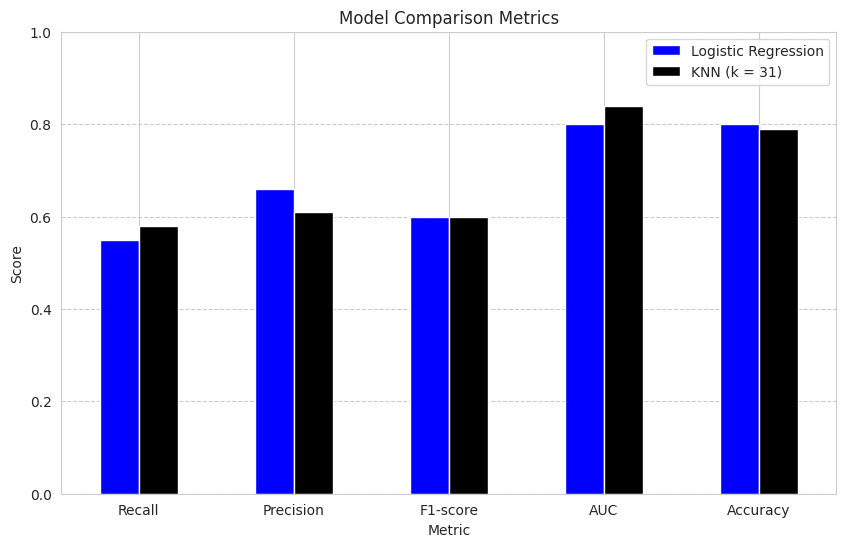

In [44]:
comparison_df.set_index("Metric (Class 1 - Churn)").plot(kind = "bar" , color= ["blue","black"])
plt.title("Model Comparison Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0,1)
plt.xticks(rotation = 0)
plt.grid(True , linestyle = "--" , axis = "y")
plt.show()

Conclusion


The latest bar plot compares the performance of Logistic Regression and KNN (k = 31) across key evaluation metrics for churn prediction.

Both models achieve similar F1-scores, which shows a comparable balance between precision and recall.
KNN slightly performs better than Logistic Regression in terms of recall, meaning it identifies more actually churned customers.
Logistic Regression shows higher precision than KNN , resulting in fewer false positive churn predictions.
The AUC score of KNN is noticeably higher, which indicates that KNN model has better overall ability to separate churned and non-churned customers across different thresholds.
Since missing churned customers is usually more costly than incorrectly identifying a customer as churned it can be said that higher recall and AOC scores can be used as main performance metrics.
Based on the comparison of two metrics and visual analysis, the KNN model (k = 31) will be selected as the final model. It provides improved churn detection capability and stronger overall class separation compared to the Logistic Regression model.